# **<u>Flower Recognition using Deep Learning</u>**

### Author - Mansi Panchal

Many times we see a flower and get curious to know more about it. But it is nearly impossible for a common man with less knowledge of flower species to accurately identify them. What makes it impossible is their existence in wide varieties of color and shape. It is just a matter of browsing on the internet to know more about a flower. But what if the link between the flower image and flower name is missing. Here comes the significance of involving machine learning algorithms in aiding such nature enthusiasts.

### **Step 1 : Importing Data from Google Drive**

Download the Image Dataset of Flowers from [here](https://www.kaggle.com/alxmamaev/flowers-recognition). And upload it to your Google Drive. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/Flowers

/gdrive/My Drive/Flowers


In [ ]:
data = "./"

The dataset I am using here for the flower recognition task contains 4332 flower images. The images are divided into five classes : **Daisy, Dandelion, Rose, Sunflower, Tulip**. For each class, there are approximately **750** photos.

In [ ]:
import os

print("Types of Flower used in Dataset -",os.listdir(data))

Types of Flower used in Dataset - ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
print("Number of Photos contained by each class -\n")

for cls in os.listdir(data) :
  print("\t", cls, ":", len(os.listdir(data + "/" + cls)))

Number of Photos contained by each class -

	 daisy : 769
	 dandelion : 1062
	 rose : 784
	 sunflower : 736
	 tulip : 984


### **Step 2 : Importing Data into Pytorch**

In the Pytorch there are various type of Datasets available in `torchvision.dataset`. All datasets are subclasses of `torch.utils.data.Dataset`

In this Project we are using `ImageFolder` Class to importing our data into Pytorch.



In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data)
len(dataset)

4332

The dataset has 4332 images. Further we'll divide this image in two sets - trainning dataset and validation dataset.

Let's look at a sample element.

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F6043F396D0>, 0)

It's a pair, consisting of a 320x263px image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using [`matplotlib`](https://matplotlib.org/), the de-facto plotting and graphing library for data science in Python.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

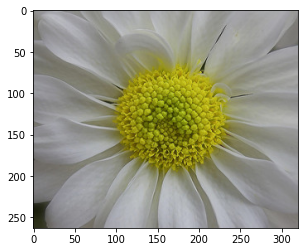

In [ ]:
img, label = dataset[0]
plt.imshow(img)

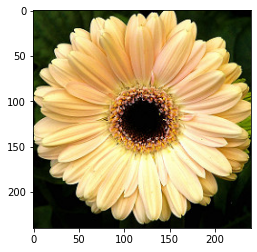

In [ ]:
img, label = dataset[20]
plt.imshow(img)

It's evident that these images are relatively small in size, and recognizing the Flowers can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

### **Step 3 : Convert Images into Pytorch Tensors**

A tensor is a number, vector, matrix, or any n-dimensional array.

In [ ]:
import torchvision.transforms as tt

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. 

We'll use the `ToTensor` transform to convert images into PyTorch tensors.

We will apply randomly chosen transformations while loading images from the dataset. Specifically, we will take a random crop of size 64 x 64 pixels. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.


In [ ]:
dataset = ImageFolder(data, tt.Compose([tt.Resize(64), 
                                        tt.RandomCrop(64),
                                        tt.ToTensor()]))

Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `3x64x64` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

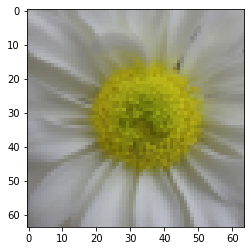

In [ ]:
img, label = dataset[0]
plt.imshow(img.permute(1, 2, 0))

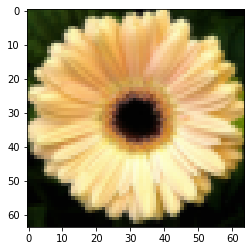

In [ ]:
img, label = dataset[20]
plt.imshow(img.permute(1, 2, 0))

### **Step 4 : Training and Validation Dataset**

While building real-world machine learning models, it is quite common to split the dataset into three parts :

**Training Set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.

**Validation Set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.

**Test Set** - used to compare different models or approaches and report the model's final accuracy.

Since there's no predefined validation set, we must manually split the 4332 images into training and validation datasets. Let's set aside 0.1% randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [ ]:
val_percent = 0.1

val_size = int(val_percent * len(dataset))
train_size = len(dataset) - val_size

print("Size of Training Dataset -", train_size)
print("Size of Validation Dataset -", val_size)

Size of Training Dataset - 3899
Size of Validation Dataset - 433


In [ ]:
from torch.utils.data import random_split, DataLoader

train_ds, val_ds = random_split(dataset, [train_size, val_size])

print("Length of Training Dataset -", len(train_ds))
print("Length of Validation Dataset -", len(val_ds))

Length of Training Dataset - 3899
Length of Validation Dataset - 433


It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of daisy's, followed by dandelion's, followed by rose's, etc. If we create a validation set using the last 20% of images, it would only consist of sunflower's and tulip's images. In contrast, the training set would contain no images of daisy,dandelion, rose. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.



In [ ]:
batch_size = 128

train_dataloader = DataLoader(train_ds, 
                              batch_size, 
                              shuffle=True,
                              num_workers=4,
                              pin_memory=True)

val_dataloader = DataLoader(val_ds,
                            batch_size, 
                            num_workers=4,
                            pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


We set `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images. 

We can look at batches of images from the dataset using the `make_grid` method from `torchvision`. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl) :
  for images, labels in dl :
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


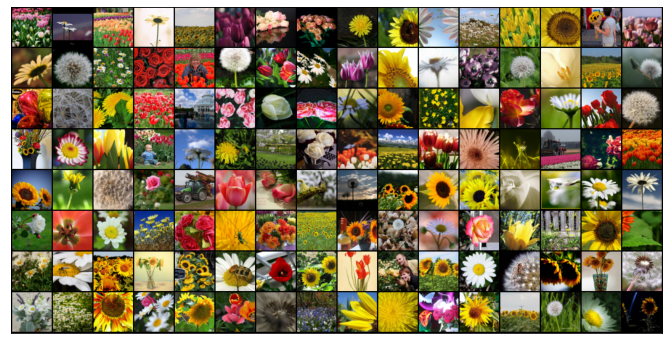

In [ ]:
show_batch(train_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


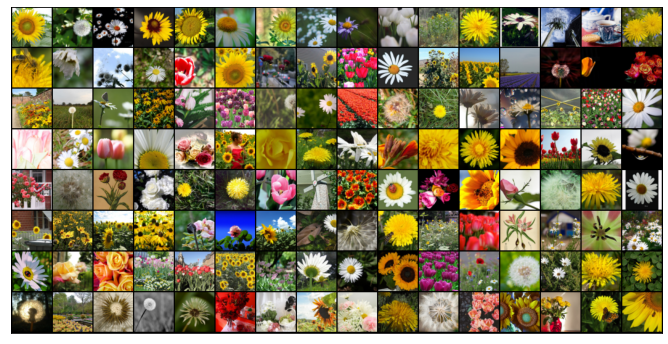

In [ ]:
show_batch(val_dataloader)

### **Step 5 : Setting of GPU Utilities**

To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required.

In [ ]:
import torch

Define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't

In [ ]:
def get_default_device():

    # Pick GPU if available, else CPU

    if torch.cuda.is_available():
        return torch.device('cuda')

    else:
        return torch.device('cpu')

Define a function that can move data and model to a chosen device

In [ ]:
def to_device(data, device):

    # Move tensor(s) to chosen device

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)

Define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [ ]:
class DeviceDataLoader():
    
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    # Yield a batch of data after moving it to device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    # Number of batches
    def __len__(self):
        return len(self.dl)

Based on where you're running this notebook, your default device could be a CPU (`torch.device('cpu')`) or a GPU (`torch.device('cuda')`)

In [ ]:
#If GPU will available it'll print True else False

torch.cuda.is_available()

True

In [ ]:
device = get_default_device()
device

device(type='cuda')

We can now wrap our training and validation data loaders using `DeviceDataLoader` for automatically transferring batches of data to the GPU (if available), and use `to_device` to move our model to the GPU (if available).

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

### **Step 6 : Setting the Training Utilities**

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model.

In [ ]:
@torch.no_grad()

def evaluate(model, val_loader):

  # Evaluate the model performance

    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):

        # Training Phase 
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The `fit` function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time.



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

Our images are of the shape 3x64x64, but we need them to be vectors of size 512, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch.

In [ ]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):

        # Calculate loss for batch of train data
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
      
        # Calculate loss and accuracy for a batch of val data
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
      
        # Calculate overall loss and acc
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### **Step 7 : Setting the CNN Utilities**

Convolutional layers are the major building blocks used in convolutional neural networks (CNN).

![](https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

A convolution is the simple application of a filter to an input that results in an activation. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image.

A simple CNN is a sequence of layers, and every layer of a CNN transforms one volume of activations to another through a differentiable function.

CNN Architecture :

![](https://miro.medium.com/max/3200/1*irQx0wao-u9jOfLIM9C-rA.png)

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
 
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),   # Convolution Layer
              nn.BatchNorm2d(out_channels),  # Normalization Layer       
              nn.ReLU(inplace=True)]    # Non-linear Activation
 
    if pool: layers.append(nn.MaxPool2d(2))   # Pooling Layer
 
    return nn.Sequential(*layers)   # Container

One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

Deeper neural networks are more difficult to train. A residual learning framework is easy to train. The layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions are explicitly reformulated. It has been shown that residual networks are easier to optimize, and can gain accuracy from considerably increased depth.

![](https://raw.githubusercontent.com/kabartay/kaggle-siim-isic-melanoma-classification/master/materials/A-cell-from-the-Residual-Network-architecture-The-identity-connection-helps-to-reduce.png)

We will use ResNet9 Architecture for our Residual Block. ResNet 9 stands for ResNet with 9 layers.

![](https://miro.medium.com/max/875/0*sdcK1I1NCqbDwiZY.png)

Here is a very simple Residual Block :

In [ ]:
class ResNet9(ImageClassificationBase):
    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Input : 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 128 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(),  # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### **Step 8 : Defining the Model**

In [ ]:
model = to_device(ResNet9(3,len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Let's verify that the model produces the expected output on a batch of training data.

In [ ]:
torch.cuda.empty_cache()

for batch in train_dataloader :
  images, labels = batch
  print("images.shape", images.shape)
  print("images.device", images.device)
  preds = model(images)
  print("preds.shape", preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


### **Step 8 : Training the Model**

In [ ]:
history = [evaluate(model, val_dataloader)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.1833944469690323, 'val_loss': 1.6083438396453857}]

The initial accuracy is around 18%, as one might expect from a randomly initialized model.

We're now ready to train our model. Instead of SGD (Stochastic Gradient Descent), we'll use the Adam optimizer which uses techniques like momentum and adaptive learning rates for faster training. You can learn more about optimizers [here](https://ruder.io/optimizing-gradient-descent/index.html).

Let's train the model for five epochs and look at the results. We can use a learning rate of 0.001.

In [ ]:
history += fit(5, 0.001, model, train_dataloader, val_dataloader, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3890, val_loss: 1.4322, val_acc: 0.3515
Epoch [1], train_loss: 0.9788, val_loss: 0.8976, val_acc: 0.6143
Epoch [2], train_loss: 0.8520, val_loss: 0.9505, val_acc: 0.6394
Epoch [3], train_loss: 0.7719, val_loss: 0.8508, val_acc: 0.7028
Epoch [4], train_loss: 0.7352, val_loss: 0.7264, val_acc: 0.7067


With just 5 epochs of training, our model has reached an accuracy of over 70% on the validation set. Let's see if we can improve that by training for a few more epochs.

In [ ]:
history += fit(5, 0.001, model, train_dataloader, val_dataloader, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.8589, val_loss: 0.7917, val_acc: 0.6891
Epoch [1], train_loss: 0.6594, val_loss: 0.6801, val_acc: 0.7172
Epoch [2], train_loss: 0.5992, val_loss: 0.7584, val_acc: 0.7149
Epoch [3], train_loss: 0.5624, val_loss: 1.0363, val_acc: 0.6250
Epoch [4], train_loss: 0.5406, val_loss: 0.5971, val_acc: 0.7689


In [ ]:
history += fit(5, 0.0001, model, train_dataloader, val_dataloader, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.3908, val_loss: 0.4644, val_acc: 0.8354
Epoch [1], train_loss: 0.3547, val_loss: 0.4712, val_acc: 0.8448
Epoch [2], train_loss: 0.3323, val_loss: 0.4534, val_acc: 0.8436
Epoch [3], train_loss: 0.3189, val_loss: 0.4421, val_acc: 0.8522
Epoch [4], train_loss: 0.3031, val_loss: 0.4430, val_acc: 0.8690


In [ ]:
history += fit(5, 0.0001, model, train_dataloader, val_dataloader, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2905, val_loss: 0.4445, val_acc: 0.8417
Epoch [1], train_loss: 0.2798, val_loss: 0.4194, val_acc: 0.8851
Epoch [2], train_loss: 0.2624, val_loss: 0.4281, val_acc: 0.8600
Epoch [3], train_loss: 0.2381, val_loss: 0.4142, val_acc: 0.8690
Epoch [4], train_loss: 0.2422, val_loss: 0.4226, val_acc: 0.8553


85% Accuracy is Pretty Good !!

While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

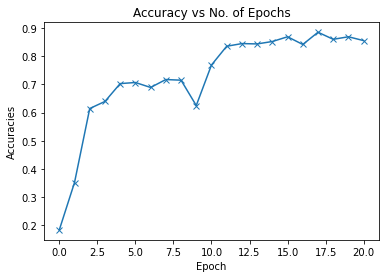

In [ ]:
acc = [x["val_acc"] for x in history]
plt.plot(acc, "-x")
plt.xlabel("Epoch")
plt.ylabel("Accuracies")
plt.title("Accuracy vs No. of Epochs")

To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations.

We can also plot the training and validation losses to study the trend.

Text(0.5, 1.0, 'Loss vs No of epochs')

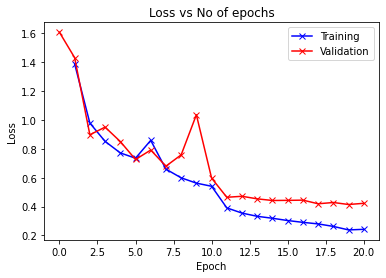

In [ ]:
train_losses = [x.get("train_loss") for x in history]
val_losses = [x["val_loss"] for x in history]
plt.plot(train_losses, "-bx")
plt.plot(val_losses, "-rx")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Loss vs No of epochs")

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point! 

<img src="https://i.stack.imgur.com/1QU0m.png" style="max-width:400px;">

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patterns are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.

Following are some common stragegies for avoiding overfitting:

- Gathering and generating more training data, or adding noise to it
- Using regularization techniques like batch normalization & dropout
- Early stopping of model's training, when validation loss starts to increase.

### **Step 9 : Testing the Model**

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. 

Let's test out our model with some images from the Validation Dataset. We begin by recreating the test dataset with the `ToTensor` transform.

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [ ]:
def predict_image(img, model, classes) :
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim = 1)
  return dataset.classes[preds[0].item()]

Define a helper function `img_test`, which returns the predicted label with image itself.

In [ ]:
def img_test(img, label) :
  plt.imshow(img.permute(1, 2, 0))
  pred = predict_image(img, model, dataset.classes)
  print("Target :", dataset.classes[label])
  print("Prediction :", pred)

Let's test Random images from Validation Dataset.

Target : sunflower
Prediction : daisy


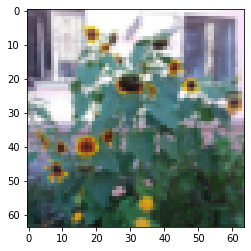

In [ ]:
img_test(*val_ds[200])

Target : tulip
Prediction : tulip


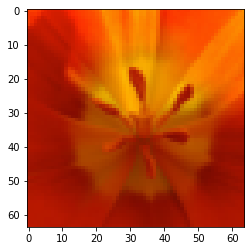

In [ ]:
img_test(*val_ds[250])

Target : daisy
Prediction : dandelion


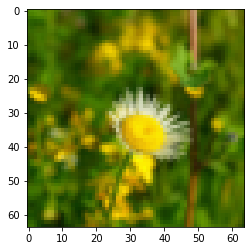

In [ ]:
img_test(*val_ds[300])

Target : daisy
Prediction : daisy


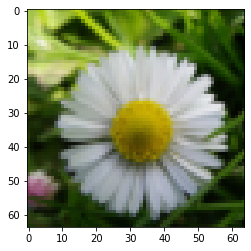

In [ ]:
img_test(*val_ds[350])

Target : rose
Prediction : rose


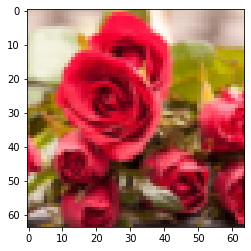

In [ ]:
img_test(*val_ds[400])

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

### **Step 10 : Save the Model**

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch. Here's how you can save the model.

In [ ]:
torch.save(model.state_dict(), "Flowers Recognition.pth")